<a href="https://colab.research.google.com/github/fernandoGitHub/ML_Projects/blob/main/Residual_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Residual Networks

Residual Networks, introduced by [He et al.](https://arxiv.org/pdf/1512.03385.pdf), allow you to train much deeper networks than were previously feasible.

**By the end of this assignment, you'll be able to:**

- Implement the basic building blocks of ResNets in a deep neural network using Keras
- Put together these building blocks to implement and train a state-of-the-art neural network for image classification
- Implement a skip connection in your network


<a name='1'></a>
## 1 - Packages

In [1]:
import numpy as np
import pandas as pd
import scipy.misc
import os
import h5py
import math

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline

from PIL import Image, ImageOps, ImageFilter, ImageEnhance

import tensorflow as tf
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.python.framework.ops import EagerTensor

In [2]:
import sys
import subprocess as sp
import pkg_resources

def install_package(package, reload = True):
  # Veryfing existing install prior to install
  if is_installed(package):
    print (f'Package: {package} is already installed. Skipping installation')
  else:
    print(f'Installing {package} ...')
    sp.check_call([sys.executable, '-m', 'pip', 'install', package])
    print(f'Package {package} has been successfully installed')

  if reload:
    reload_packages()

def is_installed (package):
  # Getting all the list of packages
  return (package in get_installed_packages())

def get_installed_packages():
  return sorted({pkg.key for pkg in pkg_resources.working_set})

def reload_packages():
  print ('Reloading Packages')
  import pkg_resources
  import importlib
  importlib.reload(pkg_resources)

In [3]:
# Enabling Multi-output on Notebook cells
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

 Here is where you're actually using the power of the Functional API to create a shortcut path: 

### 3.1 - The Identity Block

In [4]:
def identity_block(X, filters, kernel_sizes, strides, paddings, training=True, initializer=random_uniform):
    """
    Implementation of the Residual Block (any number of skips)
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape (fxf) of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    kernel_sizes -- python list of integers specifying the shape of the each filter
    strides -- pyton list of integers specifying stride values. E.g., (3, 3)
    paddings -- python list of strings indicating padding mode - (e.g., 'valid' or 'same')
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (m, n_H, n_W, n_C)
    """
    # Size of convolutions in main path
    L = len(filters) 
    
    # Save for later addition 
    X_shortcut = X
    
    for i in range(L-1):
      # Adding block
      X = Conv2D(filters = filters[i], kernel_size = kernel_sizes[i], strides = (strides[i],strides[i]), padding = paddings[i], kernel_initializer = initializer(seed=0))(X)
      X = BatchNormalization(axis = 3)(X, training=training) # Default axis
      X = Activation('relu')(X)

    ## Last component of the block - needs to receive the input for the first one
    X = Conv2D(filters = filters[L-1], kernel_size = kernel_sizes[L-1], strides = (strides[L-1],strides[L-1]), padding = paddings[L-1], kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis 
    
    ## Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = tf.keras.layers.Add()([X, X_shortcut])
    X = Activation('relu')(X) 

    return X

### 3.2 - The Convolutional Block

In [5]:
def convolutional_block(X, filters, kernel_sizes, strides, paddings, training=True, initializer=glorot_uniform):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape (fxf) of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    kernel_sizes -- python list of integers specifying the shape of the each filter
    strides -- pyton list of integers specifying stride values. E.g., (3, 3)
    paddings -- python list of strings indicating padding mode - (e.g., 'valid' or 'same')
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    # Size of convolutions in main path
    L = len(filters) 
    
    # Save for later addition 
    X_shortcut = X
    
    ##### MAIN PATH #####
    for i in range(L-1):
      # Adding block
      X = Conv2D(filters = filters[i], kernel_size = kernel_sizes[i], strides = (strides[i],strides[i]), padding = paddings[i], kernel_initializer = initializer(seed=0))(X)
      X = BatchNormalization(axis = 3)(X, training=training) # Default axis
      X = Activation('relu')(X)

    ## Last component of the block - needs to receive the input for the first one
    X = Conv2D(filters = filters[L-1], kernel_size = kernel_sizes[L-1], strides = (strides[L-1],strides[L-1]), padding = paddings[L-1], kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis 

    ##### SHORTCUT PATH ##### (≈2 lines)
    X_shortcut = Conv2D(filters = filters[L-1], kernel_size = kernel_sizes[L-1], strides = (strides[0], strides[0]), padding=paddings[L-1], kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training=training) 

    # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

<a name='4'></a>  
## 4 - Playing with ResNet (50 layers)

Let's play with a basic ResNet according to the following figure (source: Coursera, DeepLearning.ai)
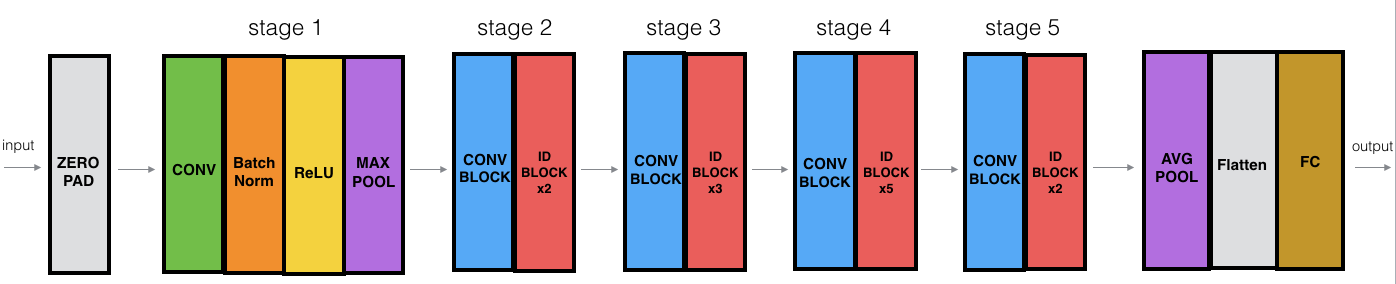
<caption><center> <u> <font color='purple'> <b>Figure 5</b> </u><font color='purple'>  : <b>ResNet-50 model</b> </center></caption>

<a name='ex-3'></a>      
### Keras Layers References:

- Average pooling [see reference](https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D)
- Conv2D: [See reference](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)
- BatchNorm: [See reference](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization) (axis: Integer, the axis that should be normalized (typically the features axis))
- Zero padding: [See reference](https://www.tensorflow.org/api_docs/python/tf/keras/layers/ZeroPadding2D)
- Max pooling: [See reference](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D)
- Fully connected layer: [See reference](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)
- Addition: [See reference](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Add)

In [6]:
def ResNet50_v1(input_shape = (64, 64, 3), classes = 6):
    """
    Stage-wise implementation of the architecture of the popular ResNet50 - Version 1.0:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)
 
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)


# def convolutional_block(X, filters, kernel_sizes, strides, paddings, training=True, initializer=glorot_uniform):
# def identity_block(X, filters, kernel_sizes, strides, paddings, training=True, initializer=random_uniform):

    filters = [64, 64, 256]
    kernel_sizes = [1, 3, 1]
    paddings=['valid', 'same', 'valid']
    strides_conv = [1, 1, 1]
    strides_id = [1, 1, 1]

    # Stage 2
    X = convolutional_block(X, kernel_sizes=kernel_sizes, filters=filters, strides=strides_conv, paddings=paddings)
    for i in range(2):
      X = identity_block(X, kernel_sizes=kernel_sizes, filters=filters, paddings=paddings, strides=strides_id)
    
    ## Stage 3 
    filters = np.multiply(filters, 2)
    strides_conv = [2, 1, 1]
    X = convolutional_block(X, kernel_sizes=kernel_sizes, filters=filters, strides=strides_conv, paddings=paddings) 
    for i in range(3):
      X = identity_block(X, kernel_sizes=kernel_sizes, filters=filters, paddings=paddings, strides=strides_id)  
    
    ## Stage 4 
    filters = np.multiply(filters, 2)
    X = convolutional_block(X, kernel_sizes=kernel_sizes, filters=filters, strides=strides_conv, paddings=paddings)
    for i in range(5): 
      X = identity_block(X, kernel_sizes=kernel_sizes, filters=filters, paddings=paddings, strides=strides_id) 

    ## Stage 5 (≈3 lines)
    filters = np.multiply(filters, 2)
    X = convolutional_block(X, kernel_sizes=kernel_sizes, filters=filters, strides=strides_conv, paddings=paddings) 
    for i in range(2):
      X = identity_block(X, kernel_sizes=kernel_sizes, filters=filters, paddings=paddings, strides=strides_id)  

    ## AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size=(2, 2))(X) 

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

Run the following code to build the model's graph. If your implementation is incorrect, you'll know it by checking your accuracy when running `model.fit(...)` below.

In [7]:
resnet50_v1_0 = ResNet50_v1(input_shape = (64, 64, 3), classes = 6)
print(resnet50_v1_0.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   9472        ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                   

As shown in the Keras Tutorial Notebook, prior to training a model, you need to configure the learning process by compiling the model.

In [8]:
resnet50_v1_0.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 4. Preparing and Loading a Dataset

The model is now ready to be trained. The only thing you need now is a dataset!

Let's use the fingers dataset for training.

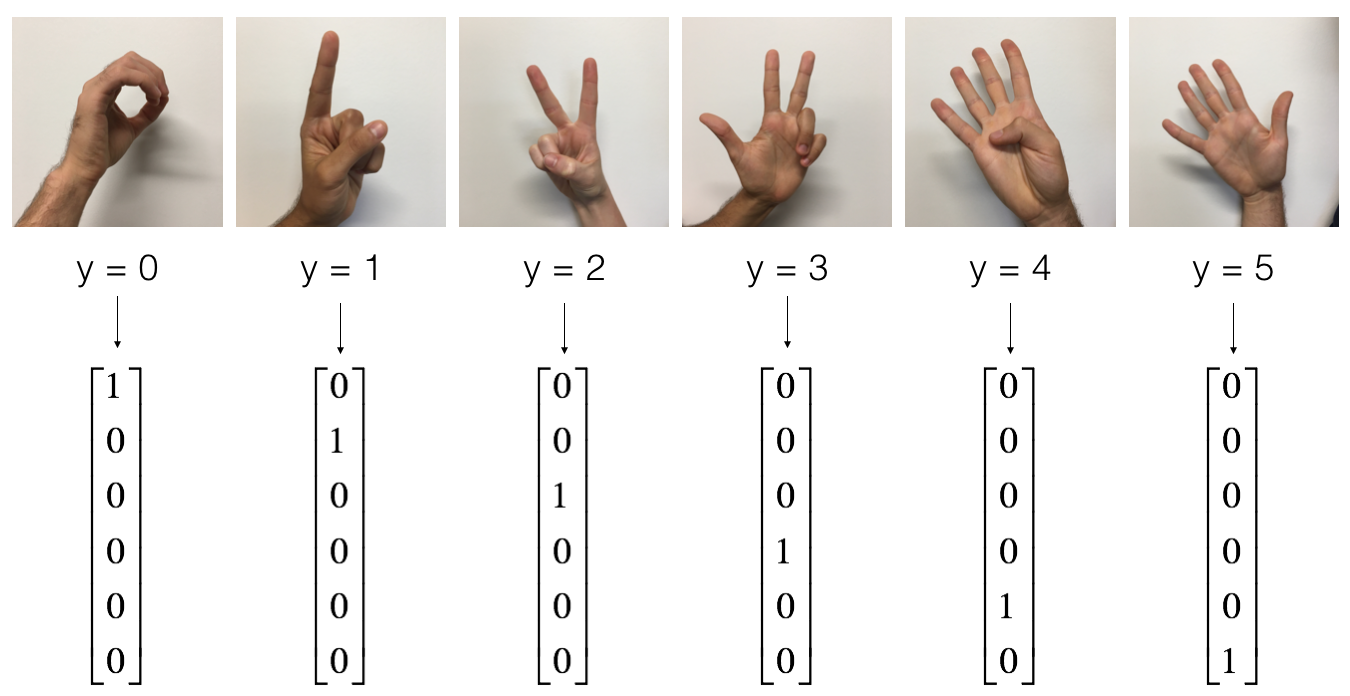

In [9]:
import os
import shutil

install_package('wget')
import wget

_DATASETS_DIR = './datasets'
_TRAIN_FILENAME = 'train_signs.h5'
_TEST_FILENAME = 'test_signs.h5'

_GITHUB_DIR_URL = 'https://github.com/fernandoGitHub/ML_Projects/raw/main/Residual_Networks/data/'
_TRAIN_URL_PATH = os.path.join(_GITHUB_DIR_URL, _TRAIN_FILENAME)
_TEST_URL_PATH =  os.path.join(_GITHUB_DIR_URL, _TEST_FILENAME)

_TRAIN_FULL_PATH = os.path.join(_DATASETS_DIR, _TRAIN_FILENAME)
_TEST_FULL_PATH =  os.path.join(_DATASETS_DIR, _TEST_FILENAME)

if os.path.isdir('./sample_data'):
  shutil.rmtree('./sample_data')
  print('Removing default sample_data directory...')

if os.path.isdir(_DATASETS_DIR):
  shutil.rmtree(_DATASETS_DIR)
  print(f'Removing old {_DATASETS_DIR} directory...')

if not os.path.isdir(_DATASETS_DIR):
  os.makedirs(_DATASETS_DIR)
  print(f'Recreating {_DATASETS_DIR} directory...')

if not os.path.isfile(_TRAIN_FULL_PATH):
  file_name = wget.download(_TRAIN_URL_PATH)
  print(f"Fetching from GitHub: {_TRAIN_FILENAME} ...")
  os.replace(os.path.join('.', _TRAIN_FILENAME), _TRAIN_FULL_PATH)

if not os.path.isfile(_TEST_FULL_PATH):
  file_name = wget.download(_TEST_URL_PATH)
  print(f"Fetching from GitHub: {_TEST_FILENAME} ...")
  os.replace(os.path.join('.', _TEST_FILENAME), _TEST_FULL_PATH)

Package: wget is already installed. Skipping installation
Reloading Packages
Removing old ./datasets directory...
Recreating ./datasets directory...
Fetching from GitHub: train_signs.h5 ...
Fetching from GitHub: test_signs.h5 ...


In [10]:
def convert_to_one_hot(Y, C):
  Y = np.eye(C)[Y.reshape(-1)].T
  return Y

def load_dataset(train_filename, test_filename, normalize=True, one_hot_conversion = True, display=True):
  # Train Set
  train_dataset = h5py.File(train_filename, "r")
  X_train = np.array(train_dataset["train_set_x"][:])  
  Y_train = np.array(train_dataset["train_set_y"][:])
  Y_train = Y_train.reshape((1, Y_train.shape[0]))

  # Test Set
  test_dataset = h5py.File(test_filename, "r")
  X_test = np.array(test_dataset["test_set_x"][:])   
  Y_test = np.array(test_dataset["test_set_y"][:])
  Y_test = Y_test.reshape((1, Y_test.shape[0]))

  classes = np.array(test_dataset["list_classes"][:])

  if normalize:
    X_train = X_train / 255.
    X_test  = X_test / 255.

  # Convert training and test labels to one hot matrices
  if one_hot_conversion:
    Y_train = convert_to_one_hot(Y_train, 6).T
    Y_test  = convert_to_one_hot(Y_test, 6).T

  if display:
    print ("number of training examples = " + str(X_train.shape[0]))
    print ("number of test examples = " + str(X_test.shape[0]))
    print ("X_train shape: " + str(X_train.shape))
    print ("Y_train shape: " + str(Y_train.shape))
    print ("X_test shape: " + str(X_test.shape))
    print ("Y_test shape: " + str(Y_test.shape))

    return X_train, Y_train, X_test, Y_test, classes

In [11]:
X_train, Y_train, X_test, Y_test, classes = load_dataset(_TRAIN_FULL_PATH, _TEST_FULL_PATH)

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [12]:
def display_images(images, index, labels=None, scale=False): 
  for i in index:
    x = images[i,:,:,:]
    if scale:
      x = x/255.0

    min_value =  np.round(np.min(x), 3)
    max_value =  np.round(np.max(x), 3)
    mean_value = np.round(np.mean(x), 3)
    print(f'Input no: {i} - image shape: {x.shape} - (min, max, mean) = ({min_value}, {max_value}, {mean_value})')
    
    if type(labels) != type(None):
      print(f"Label: {labels[i]}")

    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12,4))
    ax[0].imshow(x)
    ax[0].set_title('RGB channels')
    ax[1].imshow(x[:, :, 0])
    ax[1].set_title('R channel')
    ax[2].imshow(x[:, :, 1])
    ax[2].set_title('G channel')
    ax[3].imshow(x[:, :, 2])
    ax[3].set_title('B channel')
    plt.show()
    print('\n')

Input no: 854 - image shape: (64, 64, 3) - (min, max, mean) = (0.102, 0.925, 0.691)
Label: [0. 0. 0. 0. 1. 0.]


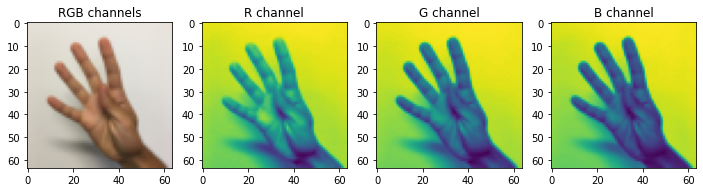



Input no: 135 - image shape: (64, 64, 3) - (min, max, mean) = (0.039, 0.918, 0.704)
Label: [1. 0. 0. 0. 0. 0.]


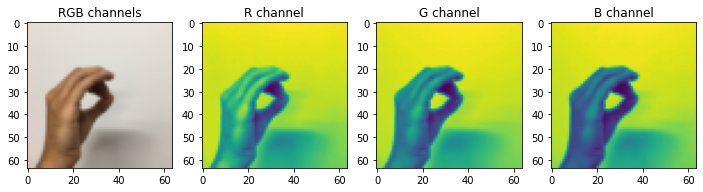



Input no: 1032 - image shape: (64, 64, 3) - (min, max, mean) = (0.051, 0.918, 0.672)
Label: [0. 0. 0. 1. 0. 0.]


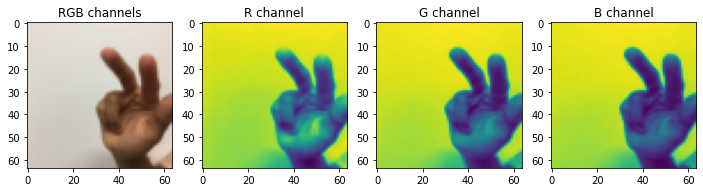



Input no: 929 - image shape: (64, 64, 3) - (min, max, mean) = (0.114, 0.929, 0.679)
Label: [0. 0. 0. 0. 0. 1.]


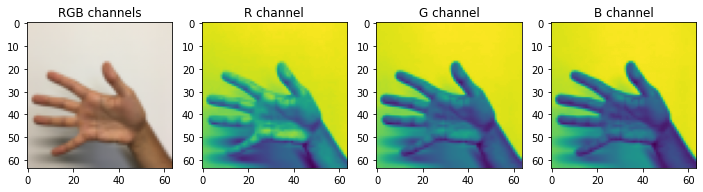



Input no: 383 - image shape: (64, 64, 3) - (min, max, mean) = (0.051, 0.918, 0.726)
Label: [0. 1. 0. 0. 0. 0.]


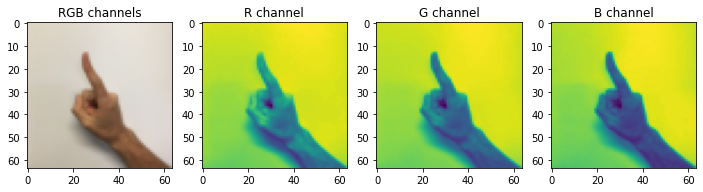



Input no: 226 - image shape: (64, 64, 3) - (min, max, mean) = (0.051, 0.933, 0.705)
Label: [0. 0. 0. 1. 0. 0.]


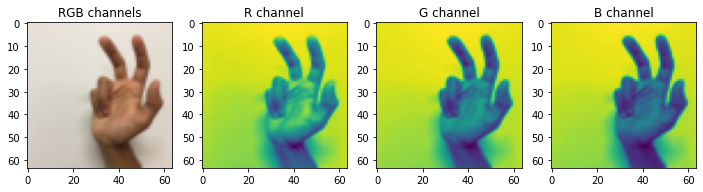



Input no: 205 - image shape: (64, 64, 3) - (min, max, mean) = (0.035, 0.933, 0.713)
Label: [1. 0. 0. 0. 0. 0.]


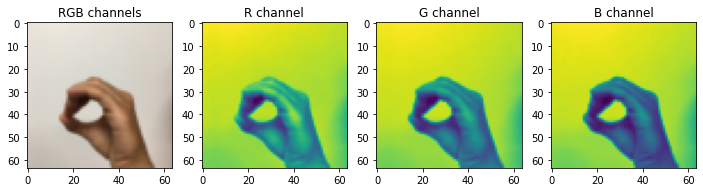



Input no: 388 - image shape: (64, 64, 3) - (min, max, mean) = (0.067, 0.925, 0.728)
Label: [0. 1. 0. 0. 0. 0.]


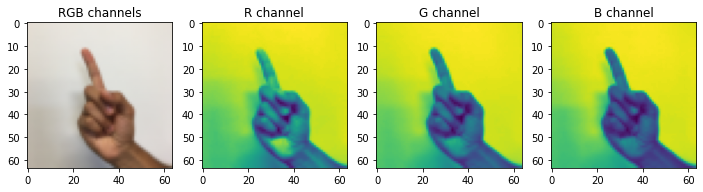



Input no: 984 - image shape: (64, 64, 3) - (min, max, mean) = (0.063, 0.925, 0.696)
Label: [0. 0. 0. 0. 0. 1.]


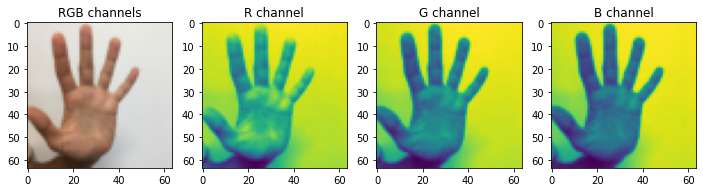



Input no: 610 - image shape: (64, 64, 3) - (min, max, mean) = (0.078, 0.922, 0.73)
Label: [0. 0. 1. 0. 0. 0.]


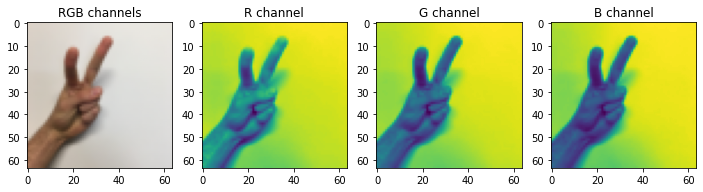



Input no: 1020 - image shape: (64, 64, 3) - (min, max, mean) = (0.09, 0.925, 0.693)
Label: [0. 0. 0. 0. 1. 0.]


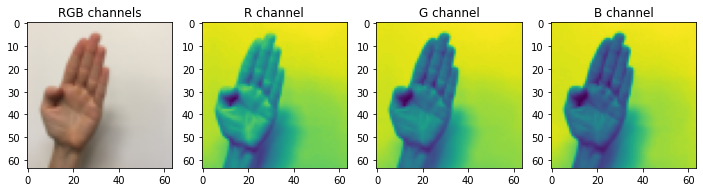



Input no: 545 - image shape: (64, 64, 3) - (min, max, mean) = (0.094, 0.922, 0.697)
Label: [0. 0. 0. 1. 0. 0.]


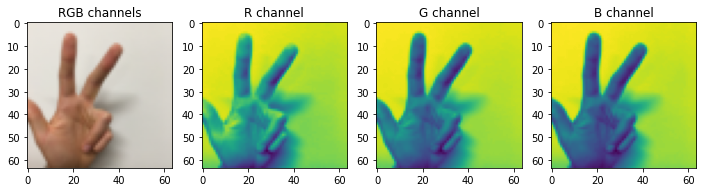



Input no: 217 - image shape: (64, 64, 3) - (min, max, mean) = (0.094, 0.929, 0.692)
Label: [0. 0. 1. 0. 0. 0.]


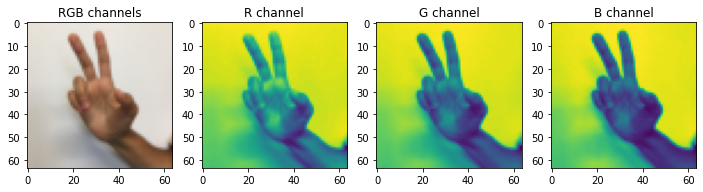



Input no: 43 - image shape: (64, 64, 3) - (min, max, mean) = (0.133, 0.933, 0.711)
Label: [0. 0. 0. 0. 1. 0.]


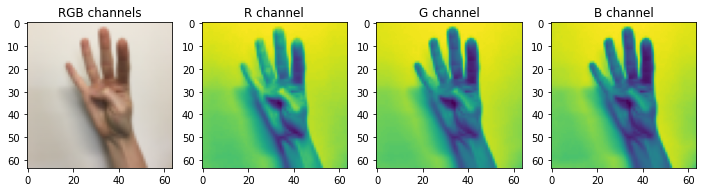



Input no: 488 - image shape: (64, 64, 3) - (min, max, mean) = (0.094, 0.929, 0.721)
Label: [0. 0. 0. 0. 0. 1.]


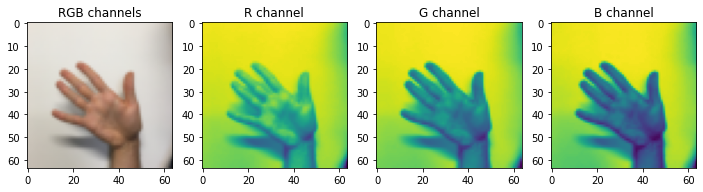



Input no: 71 - image shape: (64, 64, 3) - (min, max, mean) = (0.075, 0.929, 0.71)
Label: [0. 0. 0. 0. 1. 0.]


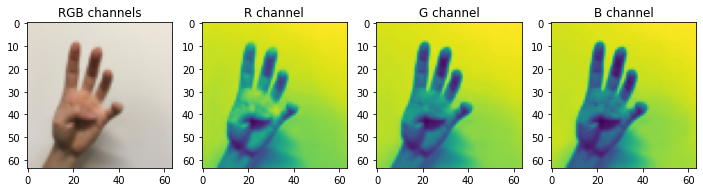



Input no: 220 - image shape: (64, 64, 3) - (min, max, mean) = (0.094, 0.925, 0.742)
Label: [0. 1. 0. 0. 0. 0.]


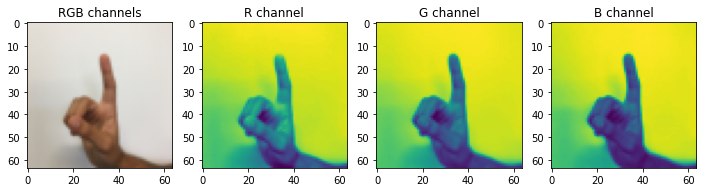



Input no: 436 - image shape: (64, 64, 3) - (min, max, mean) = (0.094, 0.925, 0.699)
Label: [0. 0. 0. 1. 0. 0.]


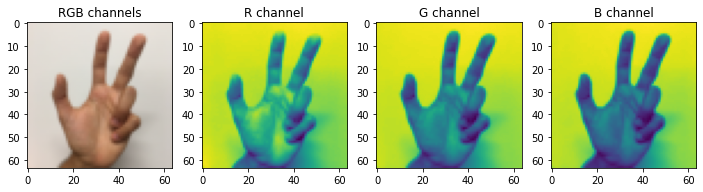



Input no: 898 - image shape: (64, 64, 3) - (min, max, mean) = (0.075, 0.925, 0.744)
Label: [0. 1. 0. 0. 0. 0.]


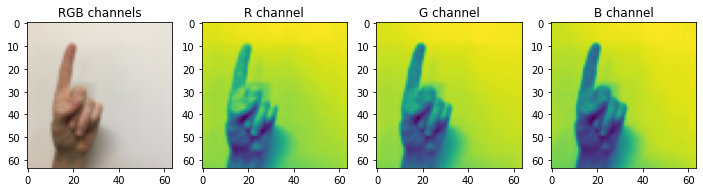



Input no: 637 - image shape: (64, 64, 3) - (min, max, mean) = (0.039, 0.922, 0.714)
Label: [1. 0. 0. 0. 0. 0.]


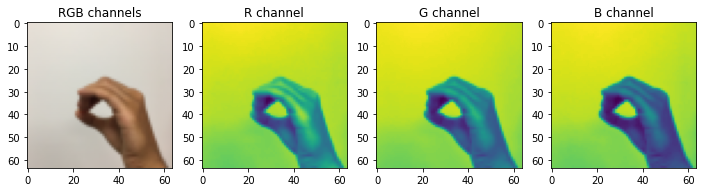



Input no: 99 - image shape: (64, 64, 3) - (min, max, mean) = (0.071, 0.925, 0.735)
Label: [0. 0. 0. 0. 0. 1.]


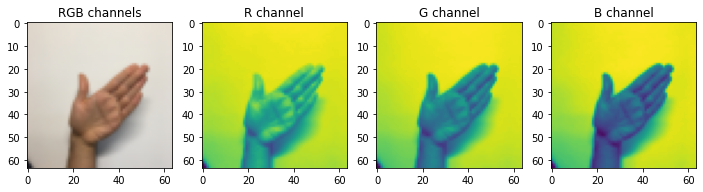



Input no: 412 - image shape: (64, 64, 3) - (min, max, mean) = (0.071, 0.902, 0.684)
Label: [1. 0. 0. 0. 0. 0.]


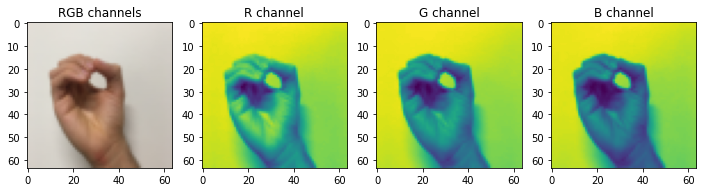



Input no: 989 - image shape: (64, 64, 3) - (min, max, mean) = (0.141, 0.91, 0.733)
Label: [0. 0. 1. 0. 0. 0.]


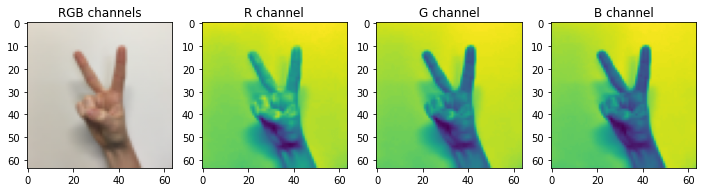



Input no: 408 - image shape: (64, 64, 3) - (min, max, mean) = (0.047, 0.933, 0.687)
Label: [0. 0. 0. 0. 1. 0.]


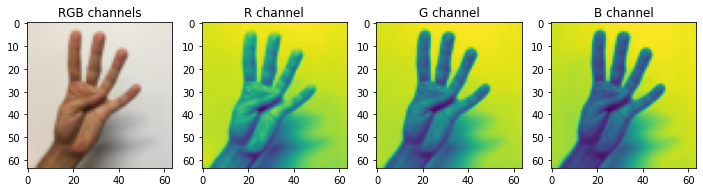



Input no: 607 - image shape: (64, 64, 3) - (min, max, mean) = (0.078, 0.922, 0.719)
Label: [0. 1. 0. 0. 0. 0.]


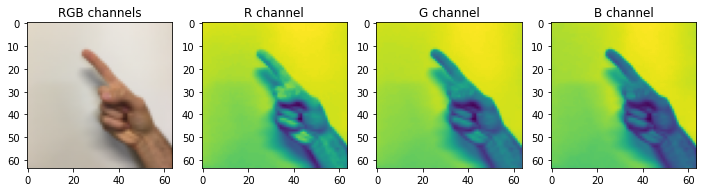



Input no: 44 - image shape: (64, 64, 3) - (min, max, mean) = (0.102, 0.925, 0.741)
Label: [0. 1. 0. 0. 0. 0.]


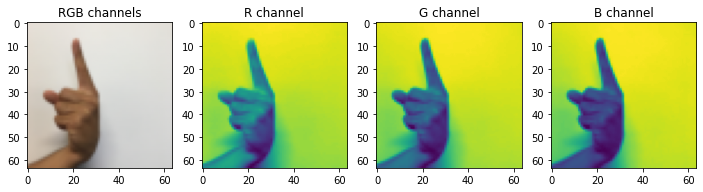



Input no: 245 - image shape: (64, 64, 3) - (min, max, mean) = (0.149, 0.918, 0.737)
Label: [0. 1. 0. 0. 0. 0.]


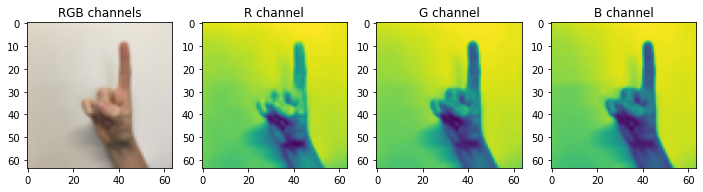

In [13]:
display_images(images=X_train, index=np.random.randint(low=0, high=len(X_train), size=27, dtype=int), labels=Y_train)

Run the following cell to train your model on 10 epochs with a batch size of 32. On a GPU, it should take less than 2 minutes. 

In [14]:
resnet50_v1_0.fit(X_train, Y_train, epochs = 40, batch_size = 32)

Epoch 1/40
34/34 [==============================] - 11s 84ms/step - loss: 1.8943 - accuracy: 0.4444
Epoch 2/40
34/34 [==============================] - 2s 57ms/step - loss: 0.4698 - accuracy: 0.8222
Epoch 3/40
34/34 [==============================] - 2s 56ms/step - loss: 0.3989 - accuracy: 0.8787
Epoch 4/40
34/34 [==============================] - 2s 57ms/step - loss: 0.3551 - accuracy: 0.8889
Epoch 5/40
34/34 [==============================] - 2s 57ms/step - loss: 0.1531 - accuracy: 0.9463
Epoch 6/40
34/34 [==============================] - 2s 57ms/step - loss: 0.0459 - accuracy: 0.9870
Epoch 7/40
34/34 [==============================] - 2s 58ms/step - loss: 0.1357 - accuracy: 0.9593
Epoch 8/40
34/34 [==============================] - 2s 58ms/step - loss: 0.3829 - accuracy: 0.9204
Epoch 9/40
34/34 [==============================] - 2s 59ms/step - loss: 0.3340 - accuracy: 0.8972
Epoch 10/40
34/34 [==============================] - 2s 58ms/step - loss: 0.1183 - accuracy: 0.9648
Epoch 11

Let's see how version 1.0 trained on 10 epochs performs on the test set.

In [15]:
preds = resnet50_v1_0.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

4/4 [==============================] - 1s 32ms/step - loss: 0.1270 - accuracy: 0.9667
Loss = 0.12704698741436005
Test Accuracy = 0.9666666388511658


In [16]:
Y_pred = resnet50_v1_0.predict(X_test)

In [17]:
matrix = tf.math.confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1))

In [18]:
matrix_df = pd.DataFrame(matrix.numpy(), columns=['Pred_'+str(i) for i in range(6)], index=['Real_'+str(i) for i in range(6)])
matrix_df.head()

Pred_0  Pred_1  Pred_2  Pred_3  Pred_4  Pred_5
Real_0      20       0       0       0       0       0
Real_1       0      19       1       0       0       0
Real_2       0       1      18       0       1       0
Real_3       0       0       0      20       0       0
Real_4       0       0       0       1      19       0

Saving the model (imperative as training takes a long time)

In [19]:
_MODELS_DIR = './models'
_MODEL_FILENAME = 'Resnet50_v1_0.h5'

_MODEL_FULL_PATH = os.path.join(_MODELS_DIR, _MODEL_FILENAME)

if not os.path.isdir(_MODELS_DIR):
  os.makedirs(_MODELS_DIR)

if os.path.isfile(_MODEL_FULL_PATH):
  os.remove(_MODEL_FULL_PATH)

print(f"Saving the model to disk as: {_MODEL_FULL_PATH} ...")
resnet50_v1_0.save(_MODEL_FULL_PATH, save_format='h5')

Saving the model to disk as: ./models/Resnet50_v1_0.h5 ...


<a name='5'></a>  
## 5 - Other images from the web (maybe also from my camera)

Let's predict results for a new dataset

In [20]:
_MODEL_FULL_PATH = './models/Resnet50_v1_0.h5'
resnet50_v1_0 = tf.keras.models.load_model(_MODEL_FULL_PATH)

In [21]:
# Adding some pictures from X_train
_IMAGES_DIR = './images'
if not os.path.isdir(_IMAGES_DIR):
  os.makedirs(_IMAGES_DIR)

for index in np.random.randint(low=0, high=len(X_train), size=10, dtype=int):
  im = Image.fromarray((X_train[index] * 255).astype(np.uint8))
  path = os.path.join('./images', 'Train'+str(index)+".JPG")
  im.save(path)

In [22]:
def load_and_preprocess_images_from_directory(img_dir, normalize=True, display=True):
  files = os.listdir(img_dir)
  JPGs = [file for file in files if (file.endswith(".jpg") or file.endswith(".JPG"))]

  images = []
  for file in files:
    img_path = os.path.join(img_dir, file)
    img = image.load_img(img_path, target_size=(64, 64))
    x = image.img_to_array(img)

    if normalize:
      x = x/255.0
  
    x = np.expand_dims(x, axis=0)
    x = np.array(x)
    if display:
      display_images(images=x, index=[0], scale=False)

    images.append((x, file))

  return images

Input no: 0 - image shape: (64, 64, 3) - (min, max, mean) = (0.024000000208616257, 1.0, 0.7080000042915344)


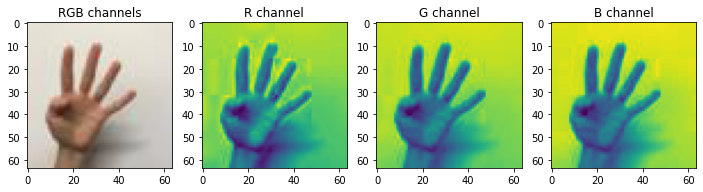



Input no: 0 - image shape: (64, 64, 3) - (min, max, mean) = (0.0, 0.953000009059906, 0.7070000171661377)


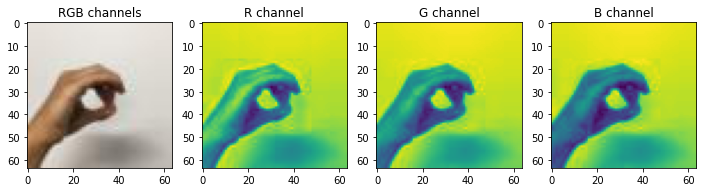



Input no: 0 - image shape: (64, 64, 3) - (min, max, mean) = (0.09399999678134918, 0.9800000190734863, 0.7120000123977661)


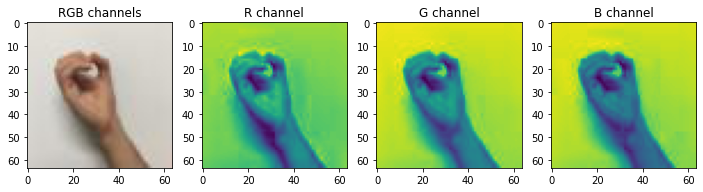



Input no: 0 - image shape: (64, 64, 3) - (min, max, mean) = (0.050999999046325684, 0.9800000190734863, 0.7039999961853027)


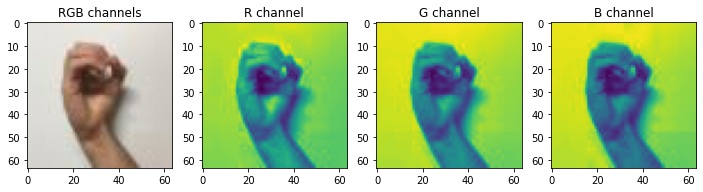



Input no: 0 - image shape: (64, 64, 3) - (min, max, mean) = (0.0820000022649765, 0.9800000190734863, 0.7400000095367432)


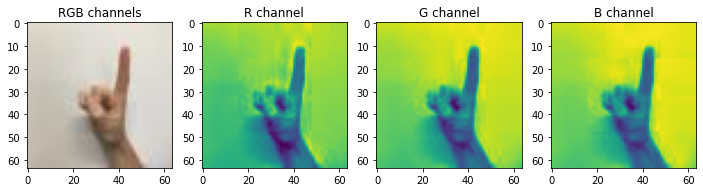



Input no: 0 - image shape: (64, 64, 3) - (min, max, mean) = (0.03099999949336052, 0.984000027179718, 0.7319999933242798)


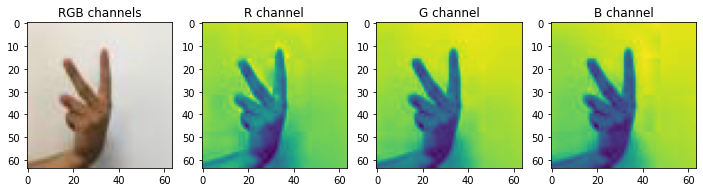



Input no: 0 - image shape: (64, 64, 3) - (min, max, mean) = (0.14499999582767487, 0.9800000190734863, 0.7450000047683716)


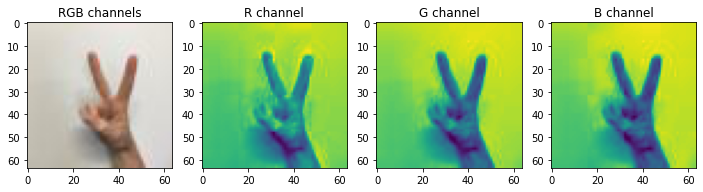



Input no: 0 - image shape: (64, 64, 3) - (min, max, mean) = (0.03500000014901161, 1.0, 0.7179999947547913)


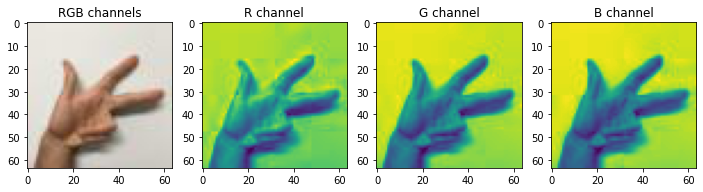



Input no: 0 - image shape: (64, 64, 3) - (min, max, mean) = (0.024000000208616257, 1.0, 0.7009999752044678)


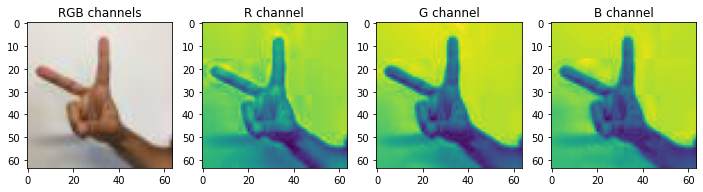



Input no: 0 - image shape: (64, 64, 3) - (min, max, mean) = (0.05900000035762787, 1.0, 0.7200000286102295)


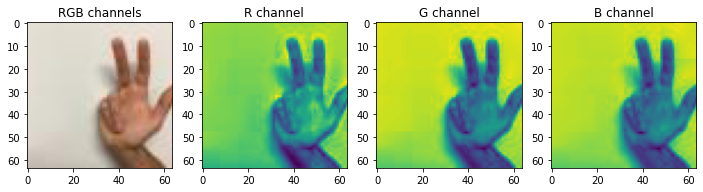



Input no: 0 - image shape: (64, 64, 3) - (min, max, mean) = (0.012000000104308128, 0.9800000190734863, 0.7350000143051147)


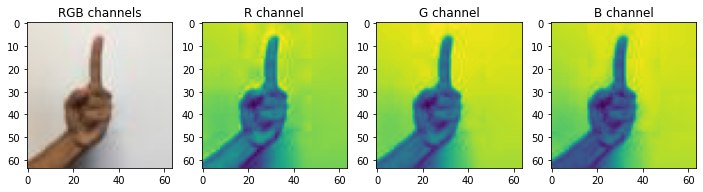



Input no: 0 - image shape: (64, 64, 3) - (min, max, mean) = (0.07100000232458115, 1.0, 0.6830000281333923)


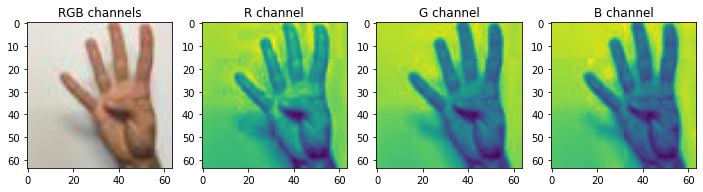



Input no: 0 - image shape: (64, 64, 3) - (min, max, mean) = (0.05900000035762787, 0.9959999918937683, 0.6990000009536743)


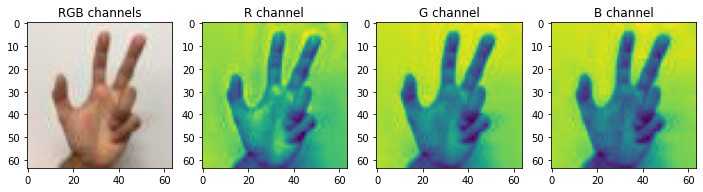



Input no: 0 - image shape: (64, 64, 3) - (min, max, mean) = (0.09000000357627869, 0.9879999756813049, 0.7279999852180481)


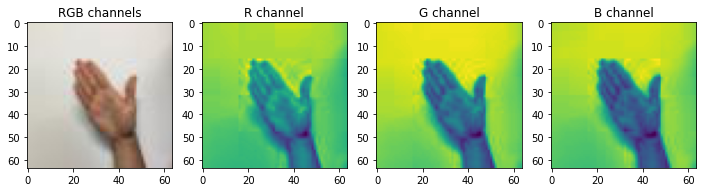



Input no: 0 - image shape: (64, 64, 3) - (min, max, mean) = (0.06300000101327896, 1.0, 0.7260000109672546)


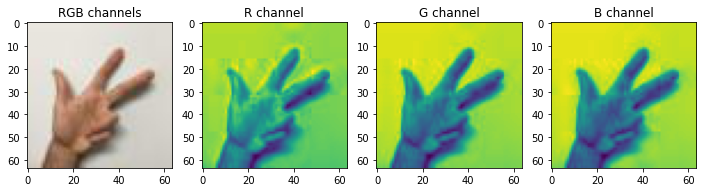



Input no: 0 - image shape: (64, 64, 3) - (min, max, mean) = (0.054999999701976776, 1.0, 0.7260000109672546)


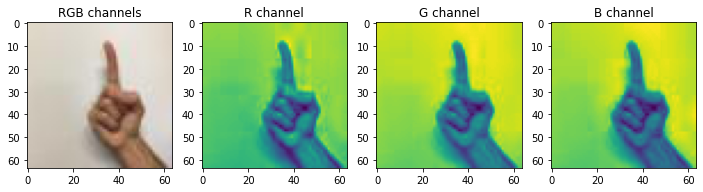



Input no: 0 - image shape: (64, 64, 3) - (min, max, mean) = (0.0430000014603138, 0.9369999766349792, 0.7440000176429749)


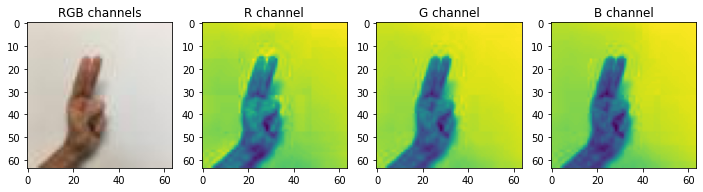



Input no: 0 - image shape: (64, 64, 3) - (min, max, mean) = (0.050999999046325684, 0.9959999918937683, 0.7250000238418579)


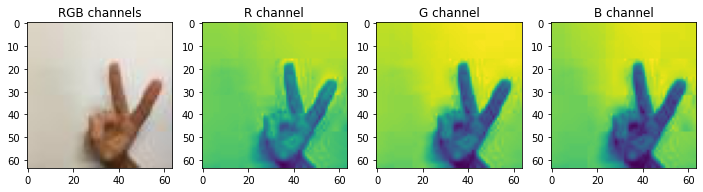



Input no: 0 - image shape: (64, 64, 3) - (min, max, mean) = (0.0, 1.0, 0.6899999976158142)


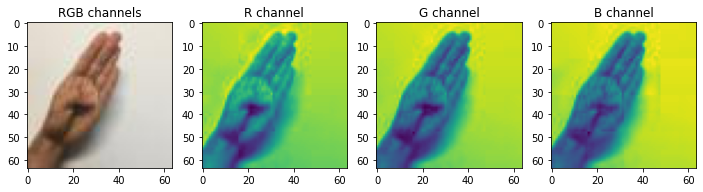



Input no: 0 - image shape: (64, 64, 3) - (min, max, mean) = (0.0, 0.968999981880188, 0.7300000190734863)


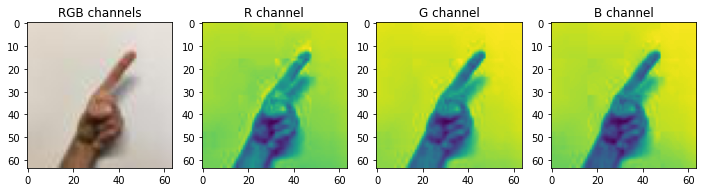

In [23]:
_IMAGES_DIR = './images'

images = load_and_preprocess_images_from_directory(img_dir=_IMAGES_DIR)

In [24]:
def predict_images(model, images, display=True):
  predictions = []
  X_test = [np.squeeze(X_image, axis=0) for i, (X_image, image_name) in enumerate(images)]
  X_names = [image_name for i, (X_image, image_name) in enumerate(images)]

  X_test = np.array(X_test)
  predictions = model.predict(X_test)
  predictions = np.round(predictions, 3)

  for i in range(X_test.shape[0]):
    if display:
      print(f"\033[1mImage Name: {X_names[i]}\033[0m")
      print(f"Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = {predictions[i]}")
      predicted_class = np.argmax(predictions[i])
      print(f"Predicted Class: {predicted_class}")
      display_images(images=np.expand_dims(X_test[i], axis=0), index=[0], scale=False)

  return predictions

Image Name: Train498.JPG
Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = [0.    0.    0.    0.    0.998 0.002]
Predicted Class: 4
Input no: 0 - image shape: (64, 64, 3) - (min, max, mean) = (0.024000000208616257, 1.0, 0.7080000042915344)


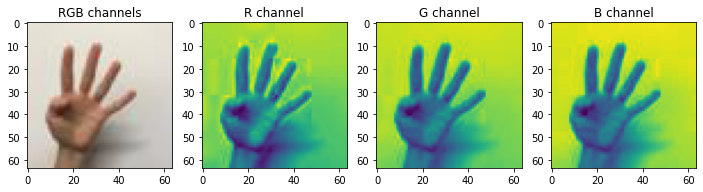



Image Name: Train346.JPG
Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = [1. 0. 0. 0. 0. 0.]
Predicted Class: 0
Input no: 0 - image shape: (64, 64, 3) - (min, max, mean) = (0.0, 0.953000009059906, 0.7070000171661377)


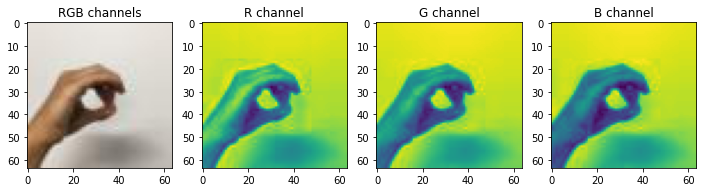



Image Name: Train661.JPG
Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = [1. 0. 0. 0. 0. 0.]
Predicted Class: 0
Input no: 0 - image shape: (64, 64, 3) - (min, max, mean) = (0.09399999678134918, 0.9800000190734863, 0.7120000123977661)


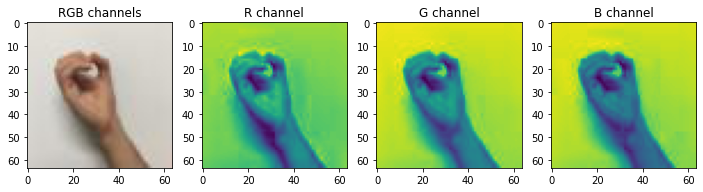



Image Name: Train402.JPG
Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = [1. 0. 0. 0. 0. 0.]
Predicted Class: 0
Input no: 0 - image shape: (64, 64, 3) - (min, max, mean) = (0.050999999046325684, 0.9800000190734863, 0.7039999961853027)


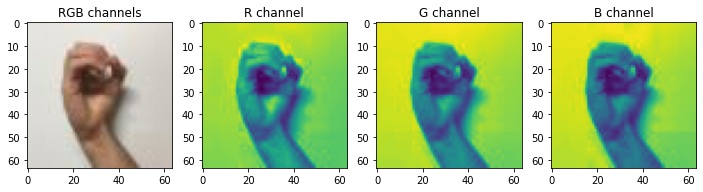



Image Name: Train96.JPG
Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = [0. 1. 0. 0. 0. 0.]
Predicted Class: 1
Input no: 0 - image shape: (64, 64, 3) - (min, max, mean) = (0.0820000022649765, 0.9800000190734863, 0.7400000095367432)


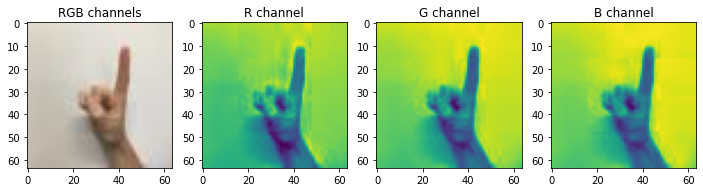



Image Name: Train72.JPG
Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = [0.    0.    0.999 0.    0.001 0.   ]
Predicted Class: 2
Input no: 0 - image shape: (64, 64, 3) - (min, max, mean) = (0.03099999949336052, 0.984000027179718, 0.7319999933242798)


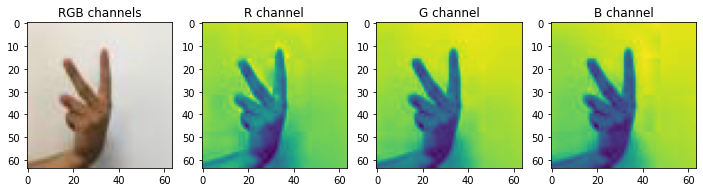



Image Name: Train503.JPG
Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = [0. 0. 1. 0. 0. 0.]
Predicted Class: 2
Input no: 0 - image shape: (64, 64, 3) - (min, max, mean) = (0.14499999582767487, 0.9800000190734863, 0.7450000047683716)


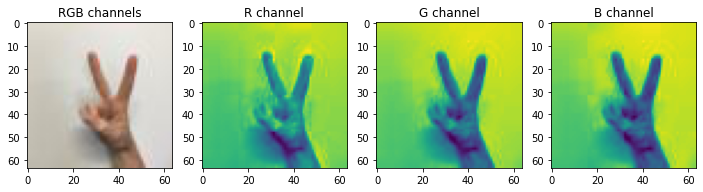



Image Name: Train289.JPG
Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = [0. 0. 0. 1. 0. 0.]
Predicted Class: 3
Input no: 0 - image shape: (64, 64, 3) - (min, max, mean) = (0.03500000014901161, 1.0, 0.7179999947547913)


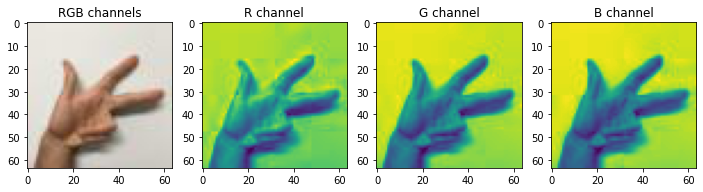



Image Name: Train107.JPG
Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = [0. 0. 1. 0. 0. 0.]
Predicted Class: 2
Input no: 0 - image shape: (64, 64, 3) - (min, max, mean) = (0.024000000208616257, 1.0, 0.7009999752044678)


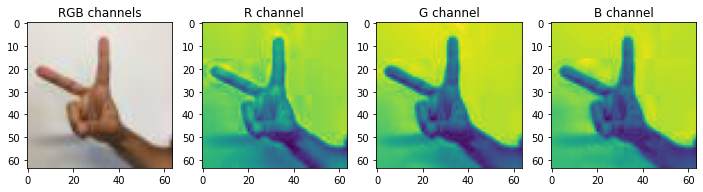



Image Name: Train355.JPG
Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = [0.003 0.    0.    0.987 0.    0.01 ]
Predicted Class: 3
Input no: 0 - image shape: (64, 64, 3) - (min, max, mean) = (0.05900000035762787, 1.0, 0.7200000286102295)


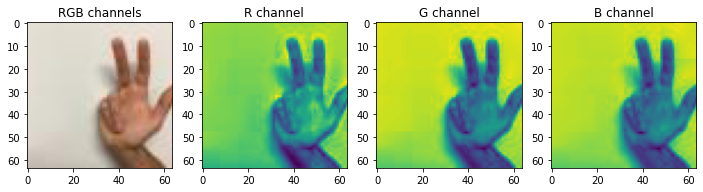



Image Name: Train878.JPG
Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = [0. 1. 0. 0. 0. 0.]
Predicted Class: 1
Input no: 0 - image shape: (64, 64, 3) - (min, max, mean) = (0.012000000104308128, 0.9800000190734863, 0.7350000143051147)


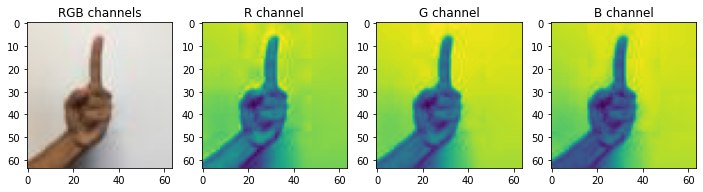



Image Name: Train155.JPG
Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = [0.    0.    0.    0.    0.999 0.001]
Predicted Class: 4
Input no: 0 - image shape: (64, 64, 3) - (min, max, mean) = (0.07100000232458115, 1.0, 0.6830000281333923)


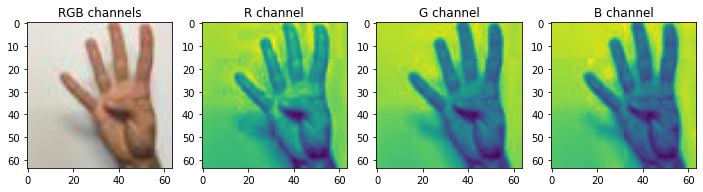



Image Name: Train436.JPG
Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = [0. 0. 0. 1. 0. 0.]
Predicted Class: 3
Input no: 0 - image shape: (64, 64, 3) - (min, max, mean) = (0.05900000035762787, 0.9959999918937683, 0.6990000009536743)


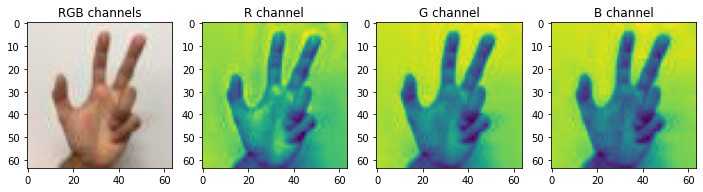



Image Name: Train799.JPG
Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = [0. 0. 0. 0. 0. 1.]
Predicted Class: 5
Input no: 0 - image shape: (64, 64, 3) - (min, max, mean) = (0.09000000357627869, 0.9879999756813049, 0.7279999852180481)


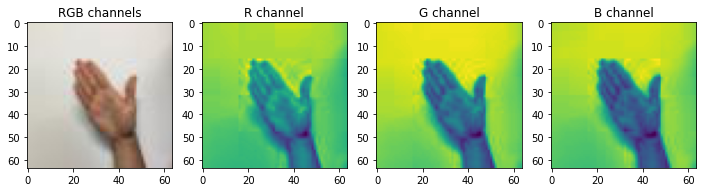



Image Name: Train577.JPG
Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = [0. 0. 0. 1. 0. 0.]
Predicted Class: 3
Input no: 0 - image shape: (64, 64, 3) - (min, max, mean) = (0.06300000101327896, 1.0, 0.7260000109672546)


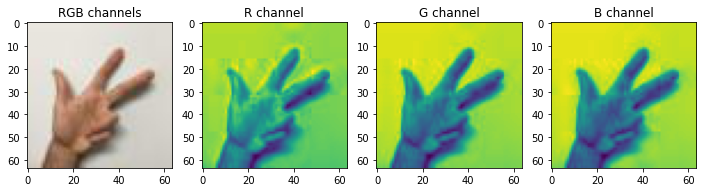



Image Name: Train126.JPG
Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = [0. 1. 0. 0. 0. 0.]
Predicted Class: 1
Input no: 0 - image shape: (64, 64, 3) - (min, max, mean) = (0.054999999701976776, 1.0, 0.7260000109672546)


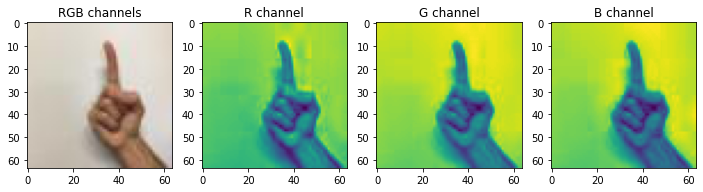



Image Name: Train514.JPG
Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = [0. 0. 1. 0. 0. 0.]
Predicted Class: 2
Input no: 0 - image shape: (64, 64, 3) - (min, max, mean) = (0.0430000014603138, 0.9369999766349792, 0.7440000176429749)


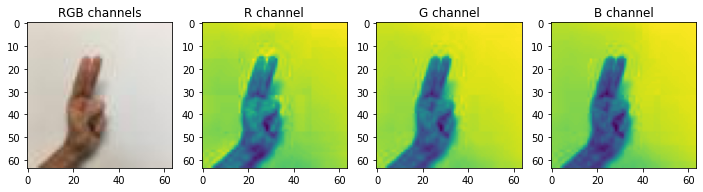



Image Name: Train452.JPG
Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = [0.    0.001 0.973 0.    0.026 0.   ]
Predicted Class: 2
Input no: 0 - image shape: (64, 64, 3) - (min, max, mean) = (0.050999999046325684, 0.9959999918937683, 0.7250000238418579)


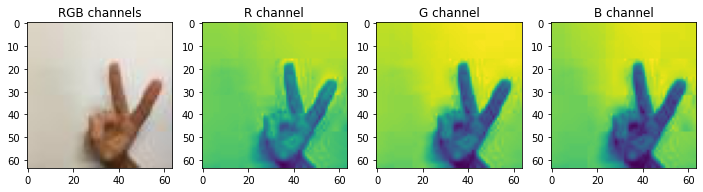



Image Name: Train829.JPG
Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = [0. 0. 0. 0. 1. 0.]
Predicted Class: 4
Input no: 0 - image shape: (64, 64, 3) - (min, max, mean) = (0.0, 1.0, 0.6899999976158142)


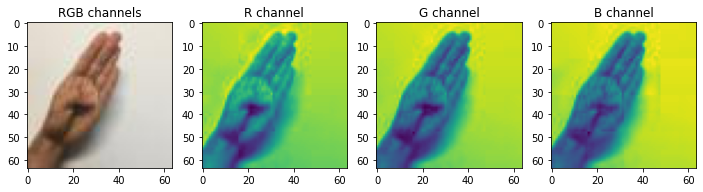



Image Name: Train520.JPG
Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = [0. 1. 0. 0. 0. 0.]
Predicted Class: 1
Input no: 0 - image shape: (64, 64, 3) - (min, max, mean) = (0.0, 0.968999981880188, 0.7300000190734863)


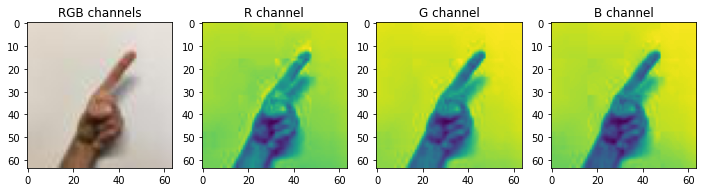

In [25]:
predictions = predict_images(model=resnet50_v1_0, images=images, display=True)

<a name='6'></a>  
## 6 - Bibliography

This notebook presents the ResNet algorithm from He et al. (2015). The implementation here also took significant inspiration and follows the structure given in the GitHub repository of Francois Chollet: 

- Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun - [Deep Residual Learning for Image Recognition (2015)](https://arxiv.org/abs/1512.03385)
- Francois Chollet's GitHub repository: https://github.com/fchollet/deep-learning-models/blob/master/resnet50.py
